In [ ]:
import qiskit
import qiskit.quantum_info
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
from qiskit_aer.primitives import Sampler as AerSampler
import matplotlib as plt

In [ ]:
backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

In [44]:
def gen_chsh(x, y, num_qubits=2):

    base_qc = qiskit.QuantumCircuit(num_qubits, 2)

    base_qc.h(0)
    base_qc.cx(0, num_qubits - 1)

    if x == 1:
        base_qc.h(0)

    if y == 0:
        base_qc.ry(-np.pi/4, num_qubits - 1)
    elif y == 1:
        base_qc.ry(np.pi/4, num_qubits - 1)   

    base_qc.measure(0, 0)
    base_qc.measure(num_qubits-1, 1)
    #measure_all() #([0, 1], [0, 1])

    return base_qc

In [86]:
circuits = []
input_pairs = []
for x_in in [0, 1]:
    for y_in in [0, 1]:
        input_pairs.append((x_in, y_in))
        circuits.append(gen_chsh(x_in, y_in, 12))

In [76]:
print(circuits)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13af9ba10>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13af9add0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13af9b850>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13af9b930>]


In [60]:
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

### Work in Progress Below

In [77]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

In [87]:
from qiskit_aer import AerSimulator
from qiskit import transpile

simulator = AerSimulator(noise_model=noise_model)
transpiled_circuits = [transpile(circ, simulator) for circ in circuits]

results = simulator.run(transpiled_circuits, shots=1024).result()
counts_list = [results.get_counts(i) for i in range(len(transpiled_circuits))]


--- Simulation Results (Counts) ---
Inputs (x=0, y=0):
  Outcomes (ba): {'00': 390, '01': 101, '10': 108, '11': 425}
Inputs (x=0, y=1):
  Outcomes (ba): {'00': 396, '01': 104, '10': 132, '11': 392}
Inputs (x=1, y=0):
  Outcomes (ba): {'00': 408, '01': 86, '10': 110, '11': 420}
Inputs (x=1, y=1):
  Outcomes (ba): {'00': 107, '01': 429, '10': 381, '11': 107}

Plotting results...


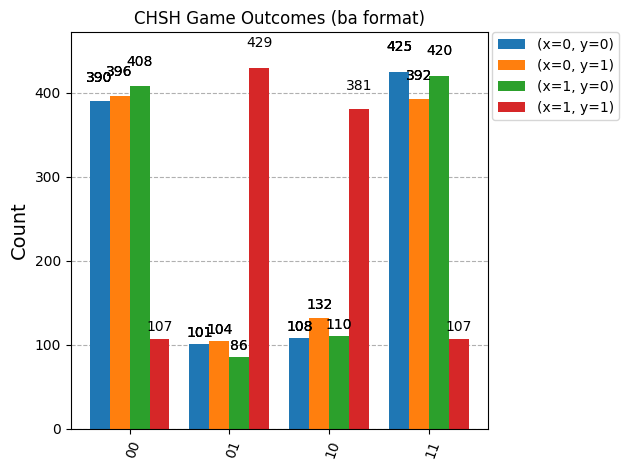

In [88]:
SHOTS=1024

print("\n--- Simulation Results (Counts) ---")
for i, (x, y) in enumerate(input_pairs):
    print(f"Inputs (x={x}, y={y}):")
    sorted_counts = dict(sorted(counts_list[i].items()))
    print(f"  Outcomes (ba): {sorted_counts}")

print("\nPlotting results...")
display(qiskit.visualization.plot_histogram(counts_list,
                       legend=[f'(x={x}, y={y})' for x, y in input_pairs],
                       title='CHSH Game Outcomes (ba format)'))

In [89]:
def get_expectation(counts):
    agree = counts.get('00', 0) + counts.get('11', 0)
    disagree = counts.get('01', 0) + counts.get('10', 0)
    return (agree - disagree) / SHOTS if SHOTS > 0 else 0

expectations = []
for (x, y), counts in zip(input_pairs, counts_list):
    e = get_expectation(counts)
    print(f"E({x},{y}) = {e:.4f}")
    expectations.append(e)

# CHSH = E(0,0) + E(0,1) + E(1,0) - E(1,1)
chsh_value = abs(expectations[0] + expectations[1] + expectations[2] - expectations[3])
print(f"\nCHSH Value: {chsh_value:.4f}")

E(0,0) = 0.5918
E(0,1) = 0.5391
E(1,0) = 0.6172
E(1,1) = -0.5820

CHSH Value: 2.3301


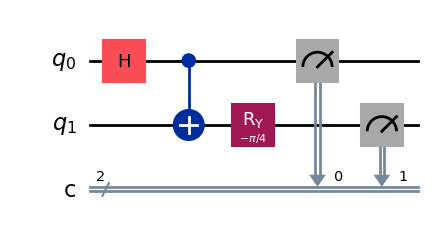

In [ ]:
qc = gen_chsh(0, 0, 2)

qc.draw('mpl')

In [3]:
def cx_chain(n_qubits):
    qc = qiskit.QuantumCircuit(n_qubits)

    half = int(n_qubits / 2)

    for i in range(half - 1):
        qc.cx(i, i + 1)
        qc.cx(i + 1, i)

        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))
        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))

    qc.cx(int(n_qubits/2)-1, int(n_qubits/2))

    for i in reversed(range(half - 1)):
        qc.cx(i + 1, i)
        qc.cx(i, i + 1)

        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))
        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))

    return qc

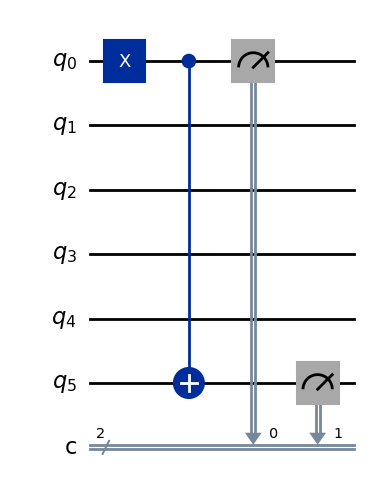

In [ ]:
custom_cnot = cx_chain(6).to_gate(label="CNOT")
qc = qiskit.QuantumCircuit(6, 2)

#qc.h(0)
qc.x(0)
#qc.append(custom_cnot, [0, 1, 2, 3, 4, 5])
qc.cx(0, 5) # used default since has lower depth after transplation
#qc.ry(-np.pi/4, 1)
qc.measure(0, 0)
qc.measure(5, 1)

qc.draw("mpl")

In [ ]:
print("Preparing circuits for the simulator...")
isa_qc_chsh = pm.run(qc)

sampler = Sampler(mode=backend)
counts = sampler.run([isa_qc_chsh], shots = 1000).result()[0].data .c.get_counts()


Preparing circuits for the simulator...


In [32]:
service = qiskit_ibm_runtime.QiskitRuntimeService()

In [33]:
print("The circuit depth is:", qc.depth())
qc_transpiled = qiskit.transpile(qc, service.backend('ibm_brisbane') , optimization_level=3)
print("The TRANSPILED circuit depth is:", qc_transpiled.depth())

The circuit depth is: 3
The TRANSPILED circuit depth is: 8
